In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os

In [2]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:

data_dir = 'dataset'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

In [4]:

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 100, 'val': 100}


['jerry', 'tom']

In [5]:

model = models.resnet18(pretrained=True)

for name, param in model.named_parameters():
    if "fc" in name:  
        param.requires_grad = True
    else:
        param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

C:\Users\advan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\advan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\advan/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [6]:

num_epochs = 10
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

train Loss: 3.0211 Acc: 0.3700
val Loss: 0.4853 Acc: 0.7700
train Loss: 0.5238 Acc: 0.7500
val Loss: 0.2171 Acc: 0.9000
train Loss: 0.6394 Acc: 0.7700
val Loss: 0.1157 Acc: 0.9600
train Loss: 0.4375 Acc: 0.7500
val Loss: 0.0740 Acc: 0.9800
train Loss: 0.4857 Acc: 0.7800
val Loss: 0.7112 Acc: 0.6700
train Loss: 0.5931 Acc: 0.7300
val Loss: 0.0525 Acc: 0.9700
train Loss: 0.2258 Acc: 0.9100
val Loss: 0.0262 Acc: 1.0000
train Loss: 0.3886 Acc: 0.8600
val Loss: 0.0208 Acc: 1.0000
train Loss: 0.3131 Acc: 0.8400
val Loss: 0.0158 Acc: 1.0000
train Loss: 0.4762 Acc: 0.7900
val Loss: 0.0180 Acc: 1.0000
Training complete!


In [7]:
# Save the model
torch.save(model.state_dict(), 'tom&jerry_classification_model.pth')

In [8]:
import torch
from torchvision import models, transforms
from PIL import Image

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('tom&jerry_classification_model.pth'))
model.eval()

new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)  

new_model.fc.weight.data = model.fc.weight.data[0:2]  
new_model.fc.bias.data = model.fc.bias.data[0:2]

In [16]:

image_path = 'C:/Users/advan/Desktop/python/dataset/val/tom/frame121.jpg'  
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  

In [17]:

with torch.no_grad():
    output = model(input_batch)

_, predicted_class = output.max(1)

class_names = ['jerry', 'tom']  
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: tom


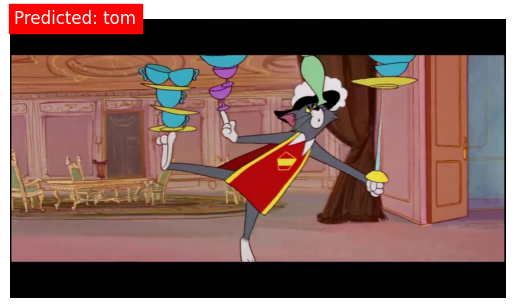

In [18]:

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()